In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd

print(tf.__version__)

2024-03-05 16:44:29.596586: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-05 16:44:29.622929: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-05 16:44:29.622954: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-05 16:44:29.623652: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-05 16:44:29.628121: I tensorflow/core/platform/cpu_feature_guar

2.15.0


In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

2024-03-05 16:44:30.798799: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-05 16:44:30.824223: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-05 16:44:30.824347: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

### Load original dataset and trained model

In [4]:
# loading dataset
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [5]:
input_shape = (28, 28, 1)

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_train = x_train / 255.0
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
x_test = x_test / 255.0

In [6]:
# one hot encoding
# y_train = tf.one_hot(y_train.astype(np.int32), depth=10)
y_test = tf.one_hot(y_test.astype(np.int32), depth=10)

2024-03-05 16:44:31.095155: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-05 16:44:31.095308: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-05 16:44:31.095380: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [7]:
record_defaults = [tf.constant([], dtype=tf.float32)] * 10

y_train = tf.data.experimental.CsvDataset(
    filenames=["noisy_y_train.csv"], record_defaults=record_defaults
)

In [8]:
# Convert the CsvDataset to a list of EagerTensors
y_train = [tf.convert_to_tensor(value) for value in y_train]

In [9]:
len(y_train)

60000

Getting model and all original hyperparameters

In [10]:
batch_size = 64
num_classes = 10
num_epochs = 30

In [11]:
optimizer = tf.keras.optimizers.SGD(name="SGD")
cce = tf.keras.losses.CategoricalCrossentropy()

In [12]:
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Conv2D(32,(5, 5), padding="same", activation="relu", input_shape=input_shape, name="conv1_1"),
        tf.keras.layers.Conv2D(32, (5, 5), padding="same", activation="relu", name="conv1_2"),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Conv2D(64, (3, 3), padding="same", activation="relu", name="conv2_1"),
        tf.keras.layers.Conv2D(64, (3, 3), padding="same", activation="relu", name="conv2_2"),
        tf.keras.layers.MaxPool2D(strides=(2, 2)),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation="relu", name="FC_1"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation="relu", name="FC_2"),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation="softmax", name="FC_softmax"),
    ]
)

model.compile(
    optimizer=tf.keras.optimizers.SGD(name="SGD"),
    loss="categorical_crossentropy",
    metrics=["acc"],
)

In [13]:
# Load gradients from the checkpoint file
checkpoint = tf.train.Checkpoint(model=model, optimizer=optimizer)
checkpoint.restore("epoch_layer_gradients.ckpt-1").expect_partial()

### Get noisy and clean samples

In [14]:
# get indices with noisy data
indices = (np.loadtxt("noisy_indices.csv", delimiter=",")).astype(int)
indices = indices.tolist()

# convert eagertensor to numpy
# y_train_numpy = [value.numpy() for value in y_train]

# create a x_batch of 1000 values using the 6k noisy examples
noisy_values_y = [y_train[i] for i in indices]
noisy_sample_y = noisy_values_y[:6000:6]

noisy_values_x = [x_train[i] for i in indices]
noisy_sample_x = noisy_values_x[:6000:6]

In [15]:
# get clean indices
total_indices = list(range(60000))
clean_indices = [value for value in total_indices if value not in indices]

# create a sample of 1000 values using the remaining 54k clean examples
clean_values_y = [y_train[i] for i in clean_indices]
clean_sample_y = clean_values_y[:54000:54]

clean_values_x = [x_train[i] for i in clean_indices]
clean_sample_x = clean_values_x[:54000:54]

In [16]:
noisy_sample_x = tf.convert_to_tensor(noisy_sample_x)
noisy_sample_y = tf.convert_to_tensor(noisy_sample_y)
clean_sample_x = tf.convert_to_tensor(clean_sample_x)
clean_sample_y = tf.convert_to_tensor(clean_sample_y)

In [17]:
print(noisy_sample_x[0].shape)
print(noisy_sample_y[0].shape)
noisy_sample = zip(noisy_sample_x, noisy_sample_y)
clean_sample = zip(clean_sample_x, clean_sample_y)

(28, 28, 1)
(10,)


The following summarizes, what we have to work with now:


*   clean_sample_x and clean_sample_y are 1000 samples of clean data
*   noisy_sample_x and noisy_sample_y are 1000 samples of noisy data



In [18]:
print("\t","noisy_sample","\t", "clean_sample", "\t","type")
print("x shape" , noisy_sample_x[0].shape,"\t",clean_sample_x[0].shape,"\t", type(noisy_sample_x[0]))
print("y shape" , noisy_sample_y[0].shape,"\t","\t",clean_sample_y[0].shape, "\t","\t",type(clean_sample_y[0]))
print("total", type(noisy_sample_x), len(noisy_sample_x))
print("total", type(clean_sample_x), len(clean_sample_x))
print("total", type(noisy_sample_y), len(noisy_sample_y))
print("total", type(clean_sample_y), len(clean_sample_y))

	 noisy_sample 	 clean_sample 	 type
x shape (28, 28, 1) 	 (28, 28, 1) 	 <class 'tensorflow.python.framework.ops.EagerTensor'>
y shape (10,) 	 	 (10,) 	 	 <class 'tensorflow.python.framework.ops.EagerTensor'>
total <class 'tensorflow.python.framework.ops.EagerTensor'> 1000
total <class 'tensorflow.python.framework.ops.EagerTensor'> 1000
total <class 'tensorflow.python.framework.ops.EagerTensor'> 1000
total <class 'tensorflow.python.framework.ops.EagerTensor'> 1000


### Load imp neurons for each example

In [19]:
import pickle

file_path = 'examples_to_neurons_clean.pkl'
with open(file_path, 'rb') as file:
    example_to_neurons = pickle.load(file)
    

In [20]:

original_pred = model(clean_sample_x)
layers = [model.get_layer("conv1_1"), model.get_layer("conv1_2"), model.get_layer("conv2_1"), model.get_layer("conv2_2"), model.get_layer("FC_1"), model.get_layer("FC_2")]
# layer_weights has 6 layers. layer_weights[] gets the layer with kernel and bias both
# layer_weights = [layer.get_weights() for layer in layers]

flips_for_clean_example = []
for ex_idx , neuron_list in enumerate(example_to_neurons):
  # if ex_idx == 1:
  #   break

  # print("on example:", ex_idx)
  for layer_idx, neuron_idx in enumerate(neuron_list):
    # print("\t on layer:", layer_idx)

    layer = layers[layer_idx]
    original_weights = layer.get_weights()

    # Check if layer is Conv or FC layer and set both kernel and bias to 0
    if layer_idx in {0,1,2,3}:
      original_weights[0][:,:,:, neuron_idx] = 0.0
      original_weights[1][neuron_idx] = 0.0
    else:
      original_weights[0][:, neuron_idx] = 0.0
      original_weights[1][neuron_idx] = 0.0
    # print("check neuron no:", neuron_idx)
    # print(original_weights)
    layer.set_weights(original_weights)
    # make a pred on new model
    pred = model(tf.expand_dims(clean_sample_x[ex_idx], axis = 0))

    # check if prediction has flipped
    if tf.argmax(pred, axis = 1) != tf.argmax(original_pred[ex_idx]):
      flips_for_clean_example.append((ex_idx, layer_idx))
      break

  checkpoint.restore("epoch_layer_gradients.ckpt-1").expect_partial()


2024-03-05 16:46:29.677356: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-05 16:46:29.732368: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-05 16:46:30.214685: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [21]:
len(flips_for_clean_example)

33

In [22]:
checkpoint.restore("epoch_layer_gradients.ckpt-1").expect_partial()

In [23]:
file_path = 'examples_to_neurons_noisy.pkl'
with open(file_path, 'rb') as file:
    example_to_neurons = pickle.load(file)

In [24]:
original_pred = model(noisy_sample_x)
layers = [model.get_layer("conv1_1"), model.get_layer("conv1_2"), model.get_layer("conv2_1"), model.get_layer("conv2_2"), model.get_layer("FC_1"), model.get_layer("FC_2")]


flips_for_noisy_example = []
for ex_idx , neuron_list in enumerate(example_to_neurons):
  # if ex_idx == 1:
  #   break

  # print("on example:", ex_idx)
  for layer_idx, neuron_idx in enumerate(neuron_list):
    # print("\t on layer:", layer_idx)

    layer = layers[layer_idx]
    original_weights = layer.get_weights()

    # Check if layer is Conv or FC layer and set both kernel and bias to 0
    if layer_idx in {0,1,2,3}:
      original_weights[0][:,:,:, neuron_idx] = 0.0
      original_weights[1][neuron_idx] = 0.0
    else:
      original_weights[0][:, neuron_idx] = 0.0
      original_weights[1][neuron_idx] = 0.0
    # print("check neuron no:", neuron_idx)
    # print(original_weights)
    layer.set_weights(original_weights)
    # make a pred on new model
    pred = model(tf.expand_dims(clean_sample_x[ex_idx], axis = 0))

    # check if prediction has flipped
    if tf.argmax(pred, axis = 1) != tf.argmax(original_pred[ex_idx]):
      flips_for_noisy_example.append((ex_idx, layer_idx))
      break

  checkpoint.restore("epoch_layer_gradients.ckpt-1").expect_partial()

In [28]:
print(len(flips_for_clean_example))
print(len(flips_for_noisy_example))

33
897


array([[1000,    7],
       [1000,    7],
       [1000,    7],
       ...,
       [1000,    7],
       [1000,    7],
       [1000,    7]])

In [139]:
import matplotlib.pyplot as plt

noisy_neurons = np.array(flips_for_noisy_example)
clean_neurons = np.array(flips_for_clean_example)

noisy_neurons[:, 1] +=1
clean_neurons[:, 1] +=1

remaining_clean = np.full((967,2), [1000,7])
remaining_noisy = np.full((103,2), [1000,7])

noisy_neurons_full = np.concatenate((noisy_neurons,remaining_noisy), axis = 0)
clean_neurons_full = np.concatenate((clean_neurons,remaining_clean), axis = 0)

## Number of neurons to be zero-ed out for flipping prediction

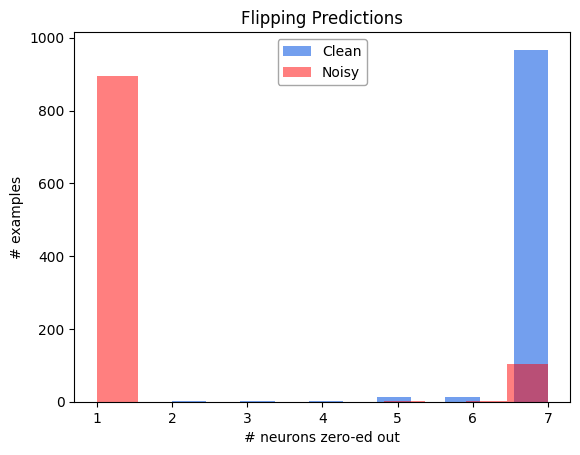

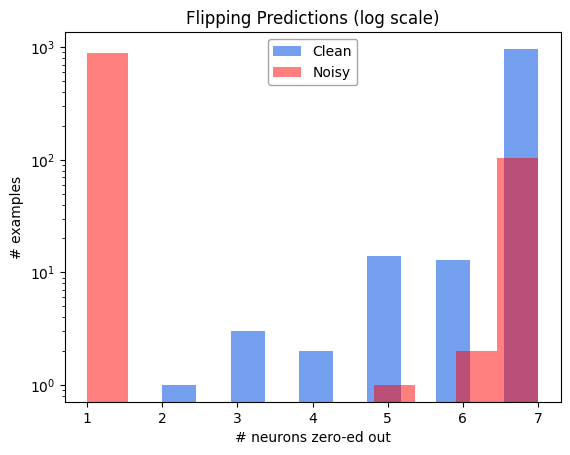

In [207]:
plt.figure()
plt.hist(clean_neurons_full[:,1], bins = "auto", color = "#6495ED", alpha = 0.9, label= "Clean")
plt.hist(noisy_neurons_full[:,1], bins = "auto", color = "red", alpha = 0.5, label= "Noisy")
plt.xlabel("# neurons zero-ed out")
plt.ylabel("# examples")
plt.title("Flipping Predictions")
plt.legend(loc = "upper center", frameon = True, framealpha = 0.7, edgecolor= "gray")
plt.show()

plt.figure()
plt.hist(clean_neurons_full[:,1], bins = "auto", color = "#6495ED", alpha = 0.9, label= "Clean",  log = True)
plt.hist(noisy_neurons_full[:,1], bins = "auto", color = "red", alpha = 0.5, label= "Noisy", log = True)
plt.xlabel("# neurons zero-ed out")
plt.ylabel("# examples")
plt.title("Flipping Predictions (log scale)")
plt.legend(loc = "best", frameon = True, framealpha = 0.7, edgecolor= "gray")
plt.show()




### Interpretation of Results
The above graphs describe the number of neurons needed to be zero-ed out to flip there respective predictions.  
Number 7 marks examples that did not flip at all.
The first graph is in an absolute scale, while the second graph uses log scaling for a clearer analysis of the clean examples.

* Noisy examples need fewer neurons to flip their prediction.  
Of the 1000 noisy examples 897 were memorized.   
This is in line with the results of the paper (Maini et al.), which suggest that those examples were memorized by the model.  
* Clean examples are more spread out over the range between 1 to 6.   
Of the 1000 noisy examples 33 were memorized.  
We assume that the model overfitted for these examples and that those examples where mostly memorized by multiple neurons.  


## Overlap of neurons per layer

In [91]:
file_path = 'examples_to_neurons_clean.pkl'
with open(file_path, 'rb') as file:
    example_to_neurons_clean = pickle.load(file)

file_path = 'examples_to_neurons_noisy.pkl'
with open(file_path, 'rb') as file:
    example_to_neurons_noisy = pickle.load(file)

In [95]:
example_to_neurons_clean = np.array(example_to_neurons_clean)
example_to_neurons_noisy = np.array(example_to_neurons_noisy)

In [114]:
def neuron_frequency(layer):
    neuron, count = np.unique(layer, return_counts= True)
    frequencies = dict(zip(neuron, count))

    return frequencies

layer1= neuron_frequency(example_to_neurons_clean.T[0])
layer2= neuron_frequency(example_to_neurons_clean.T[1])
layer3= neuron_frequency(example_to_neurons_clean.T[2])
layer4= neuron_frequency(example_to_neurons_clean.T[3])
layer5= neuron_frequency(example_to_neurons_clean.T[4])
layer6= neuron_frequency(example_to_neurons_clean.T[5])

nlayer2= neuron_frequency(example_to_neurons_noisy.T[1])
nlayer1= neuron_frequency(example_to_neurons_noisy.T[0])
nlayer3= neuron_frequency(example_to_neurons_noisy.T[2])
nlayer4= neuron_frequency(example_to_neurons_noisy.T[3])
nlayer5= neuron_frequency(example_to_neurons_noisy.T[4])
nlayer6= neuron_frequency(example_to_neurons_noisy.T[5])


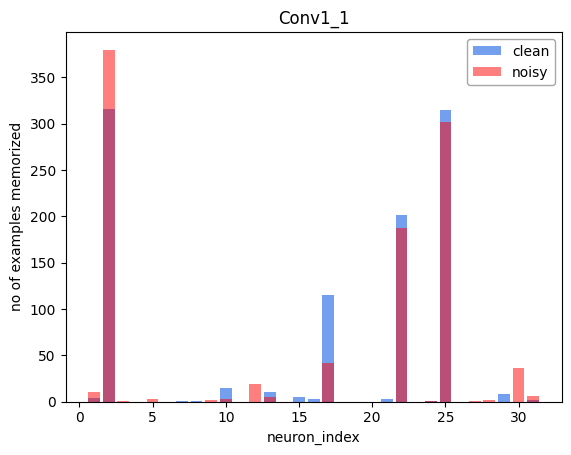

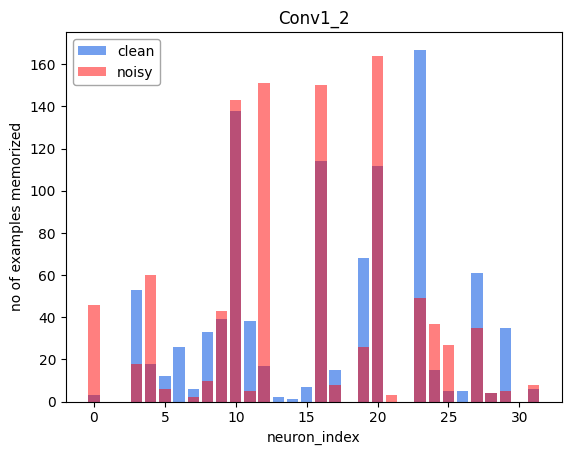

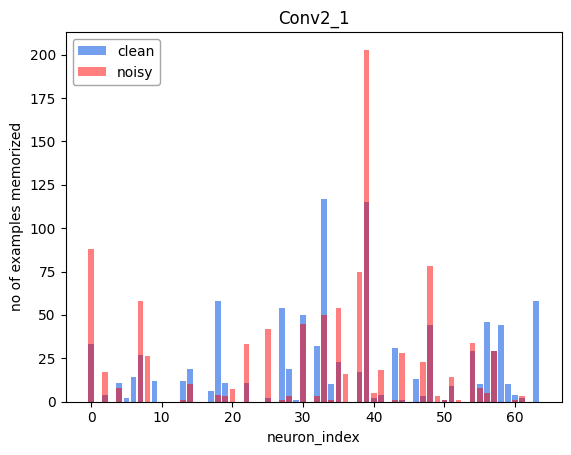

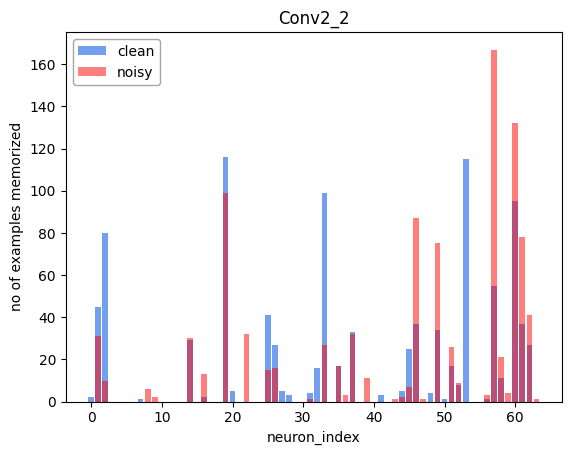

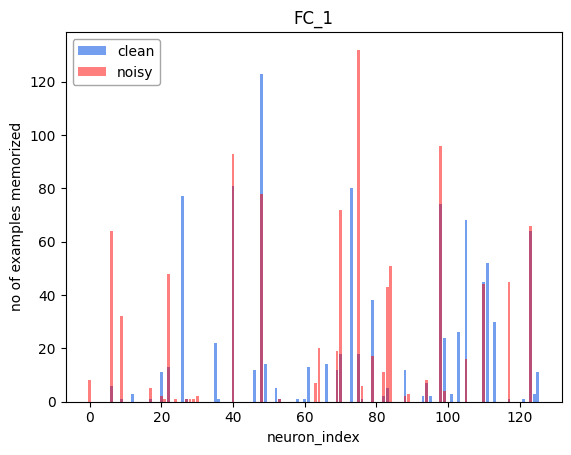

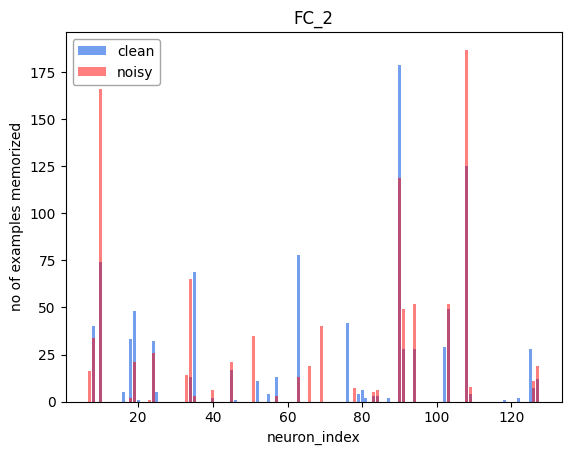

In [205]:
plt.figure()
plt.bar(layer1.keys(), layer1.values(), color = "#6495ED", alpha = 0.9, label= "clean")
plt.bar(nlayer1.keys(), nlayer1.values(), color = "red", alpha = 0.5, label= "noisy")
plt.xlabel("neuron_index")
plt.ylabel("no of examples memorized")
plt.legend(loc = "upper right", frameon = True, framealpha = 0.7, edgecolor= "gray")
plt.title("Conv1_1")
plt.show()

plt.figure()
plt.bar(layer2.keys(), layer2.values(), color = "#6495ED", alpha = 0.9, label= "clean")
plt.bar(nlayer2.keys(), nlayer2.values(), color = "red", alpha = 0.5, label= "noisy")
plt.xlabel("neuron_index")
plt.ylabel("no of examples memorized")
plt.legend(loc = "upper left", frameon = True, framealpha = 0.7, edgecolor= "gray")
plt.title("Conv1_2")
plt.show()

plt.figure()
plt.bar(layer3.keys(), layer3.values(), color = "#6495ED", alpha = 0.9, label= "clean")
plt.bar(nlayer3.keys(), nlayer3.values(), color = "red", alpha = 0.5, label= "noisy")
plt.xlabel("neuron_index")
plt.ylabel("no of examples memorized")
plt.legend(loc = "upper left", frameon = True, framealpha = 0.7, edgecolor= "gray")
plt.title("Conv2_1")
plt.show()

plt.figure()
plt.bar(layer4.keys(), layer4.values(), color = "#6495ED", alpha = 0.9, label= "clean")
plt.bar(nlayer4.keys(), nlayer4.values(), color = "red", alpha = 0.5, label= "noisy")
plt.xlabel("neuron_index")
plt.ylabel("no of examples memorized")
plt.legend(loc = "upper left", frameon = True, framealpha = 0.7, edgecolor= "gray")
plt.title("Conv2_2")
plt.show()

plt.figure()
plt.bar(layer5.keys(), layer5.values(), color = "#6495ED", alpha = 0.9, label= "clean")
plt.bar(nlayer5.keys(), nlayer5.values(), color = "red", alpha = 0.5, label= "noisy")
plt.xlabel("neuron_index")
plt.ylabel("no of examples memorized")
plt.legend(loc = "upper left", frameon = True, framealpha = 0.7, edgecolor= "gray")
plt.title("FC_1")
plt.show()

plt.figure()
plt.bar(layer6.keys(), layer6.values(), color = "#6495ED", alpha = 0.9, label= "clean")
plt.bar(nlayer6.keys(), nlayer6.values(), color = "red", alpha = 0.5, label= "noisy")
plt.xlabel("neuron_index")
plt.ylabel("no of examples memorized")
plt.legend(loc = "upper left", frameon = True, framealpha = 0.7, edgecolor= "gray")
plt.title("FC_2")
plt.show()



### Interpretation Results

Firstly, We can see for most examples (both clean and noisy), the neurons memorizing have a large over lap.
Only a few neurons per layer are memorizing most examples.

Moreover, the memorizing neurons are spread out in all layers. 



## Labels memorized

In [175]:
example_label_clean = []
for idx in clean_neurons[:,0]:
    example_label_clean.append([idx, tf.argmax(clean_sample_y[idx])])
example_label_clean = np.array(example_label_clean)

example_label_noisy = []
for idx in noisy_neurons[:,0]:
    example_label_noisy.append([idx, tf.argmax(clean_sample_y[idx])])
example_label_noisy = np.array(example_label_noisy)

file_path = 'examples_to_neurons_clean.pkl'
with open(file_path, 'rb') as file:
    example_to_neurons_clean = pickle.load(file)
example_to_neurons_clean = np.array(example_to_neurons_clean)

file_path = 'examples_to_neurons_noisy.pkl'
with open(file_path, 'rb') as file:
    example_to_neurons_noisy = pickle.load(file)
    example_to_neurons_noisy = np.array(example_to_neurons_noisy)

In [176]:
clean_flipped_idx = example_label_clean[:, 0]
noisy_flipped_idx = example_label_noisy[:, 0]

clean_summary = np.hstack((example_label_clean, example_to_neurons_clean[clean_flipped_idx]))
noisy_summary = np.hstack((example_label_noisy, example_to_neurons_noisy[noisy_flipped_idx]))

columns = ["example_idx", "label", "Conv1_1", "Conv1_2", "Conv2_1", "Conv2_2", "FC_1", "FC_2"]
clean_summary = pd.DataFrame(clean_summary, columns = columns)
noisy_summary = pd.DataFrame(noisy_summary, columns = columns)

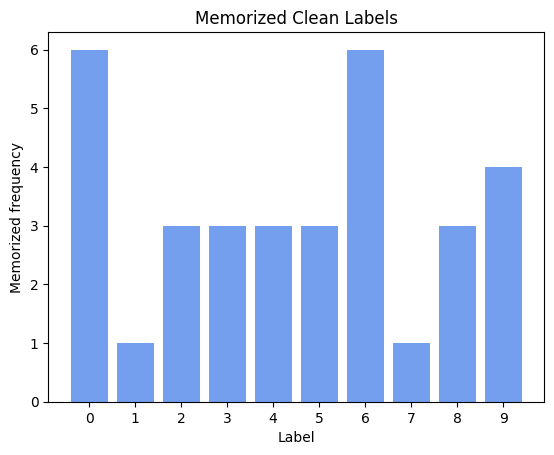

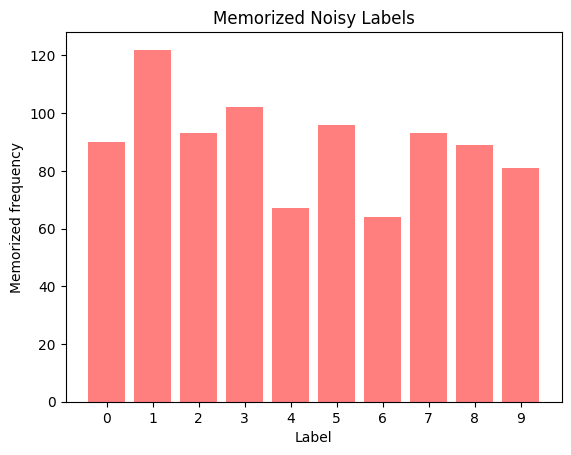

In [204]:
plt.figure()
clabel_summary = neuron_frequency(clean_summary['label'])
plt.bar(clabel_summary.keys(), clabel_summary.values(), color = "#6495ED", alpha = 0.9)
plt.xlabel("Label")
plt.ylabel("Memorized frequency")
plt.title("Memorized Clean Labels")
plt.xticks(np.arange(0,10))
plt.show()

plt.figure()
nlabel_summary = neuron_frequency(noisy_summary['label'])
plt.bar(nlabel_summary.keys(), nlabel_summary.values(), color = "red", alpha = 0.5)
plt.xlabel("Label")
plt.ylabel("Memorized frequency")
plt.title("Memorized Noisy Labels")
plt.xticks(np.arange(0,10))
plt.show()

### Interpreting Results

The labels 0 and 6 seem to be the most memorized. This could be due to how similar the two digits are in writing.  
While the remaining labels seem to be equally memorized (However, these are only a handful examples out of 1000 examples).  
This shows that the model has over all generalized well on clean examples.  

For noisy labels (i.e. mislabeled), the model had to memorize almost all labels.   
This makes sense, since the preidctions don't match with the generalization of the datapoints.